In [ ]:
!pip install kaggle

In [ ]:
! pip install -q git+https://github.com/keras-team/keras-cv

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 13.8 MB/s eta 0:00:00


In [ ]:
# mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
# You can use `tensorflow`, `pytorch`, `jax` here
# KerasCore makes the notebook backend agnostic :)
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras_cv
import keras_core as keras
from keras_core import layers

import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

Using TensorFlow backend


keras starter 기반으로 작성된 노트북

Config

In [ ]:
class Config:
    SEED = 42
    IMAGE_SIZE = [256, 256]
    BATCH_SIZE = 64
    EPOCHS = 10
    TARGET_COLS = [
        "bowel_injury", "extravasation_injury",
        "kidney_healthy", "kidney_low", "kidney_high",
        "liver_healthy", "liver_low", "liver_high",
        "spleen_healthy", "spleen_low", "spleen_high",
    ]
    AUTOTUNE = tf.data.AUTOTUNE

config = Config()

In [ ]:
keras.utils.set_random_seed(seed=config.SEED)

Dataset

In [ ]:
BASE_PATH = "/content/drive/MyDrive/test/rsna-atd-512x512-png-v2-dataset"

In [ ]:
# train
dataframe = pd.read_csv(f"{BASE_PATH}/train.csv")
dataframe["image_path"] = f"{BASE_PATH}/train_images"\
                    + "/" + dataframe.patient_id.astype(str)\
                    + "/" + dataframe.series_id.astype(str)\
                    + "/" + dataframe.instance_number.astype(str) +".png"
dataframe = dataframe.drop_duplicates()

dataframe.head(2)

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,...,spleen_healthy,spleen_low,spleen_high,any_injury,series_id,instance_number,injury_name,image_path,width,height
0,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,362,Active_Extravasation,/content/drive/MyDrive/test/rsna-atd-512x512-p...,512,512
1,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,363,Active_Extravasation,/content/drive/MyDrive/test/rsna-atd-512x512-p...,512,512


In [ ]:
# Function to handle the split for each group
def split_group(group, test_size=0.2):
    if len(group) == 1:
        return (group, pd.DataFrame()) if np.random.rand() < test_size else (pd.DataFrame(), group)
    else:
        return train_test_split(group, test_size=test_size, random_state=42)

# Initialize the train and validation datasets
train_data = pd.DataFrame()
val_data = pd.DataFrame()

# Iterate through the groups and split them, handling single-sample groups
for _, group in dataframe.groupby(config.TARGET_COLS):
    train_group, val_group = split_group(group)
    train_data = pd.concat([train_data, train_group], ignore_index=True)
    val_data = pd.concat([val_data, val_group], ignore_index=True)

In [ ]:
train_data.shape, val_data.shape

((9612, 21), (2417, 21))

In [ ]:
def decode_image_and_label(image_path, label):
    file_bytes = tf.io.read_file(image_path)
    image = tf.io.decode_png(file_bytes, channels=3, dtype=tf.uint8)
    image = tf.image.resize(image, config.IMAGE_SIZE, method="bilinear")
    image = tf.cast(image, tf.float32) / 255.0

    label = tf.cast(label, tf.float32)
    labels = (label[0:1], label[1:2], label[2:5], label[5:8], label[8:11])

    return (image, labels)

In [ ]:
# 레이어 외부에서 RandomFlip 레이어를 생성
random_flip_layer = tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal")
random_rotation_layer = tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)

class CustomAugmenter(tf.keras.layers.Layer):
    def __init__(self, cutout_params, **kwargs):
        super(CustomAugmenter, self).__init__(**kwargs)
        self.cutout_layer = keras_cv.layers.Augmenter([keras_cv.layers.RandomCutout(**cutout_params)])

    def call(self, inputs, training=None):
        if training:
            inputs = random_flip_layer(inputs)
            inputs = random_rotation_layer(inputs)
            inputs = self.cutout_layer(inputs)
        return inputs

def apply_augmentation(images, labels):
    # 이미지 증강 파이프라인을 정의
    augmenter = CustomAugmenter(cutout_params={"height_factor": 0.2, "width_factor": 0.2})

    # 이미지 증강을 적용
    augmented_images = augmenter(images, training=True)

    return (augmented_images, labels)

In [ ]:
def build_dataset(image_paths, labels):
    ds = (
        tf.data.Dataset.from_tensor_slices((image_paths, labels))
        .map(decode_image_and_label, num_parallel_calls=config.AUTOTUNE)
        .shuffle(config.BATCH_SIZE * 10)
        .batch(config.BATCH_SIZE)
        .map(apply_augmentation, num_parallel_calls=config.AUTOTUNE)  # 이미지 증강 적용
        .prefetch(config.AUTOTUNE)
    )
    return ds

In [ ]:
paths = train_data.image_path.tolist()
labels = train_data[config.TARGET_COLS].values

ds = build_dataset(image_paths=paths, labels=labels)
images, labels = next(iter(ds))
images.shape, [label.shape for label in labels]

(TensorShape([64, 256, 256, 3]),
 [TensorShape([64, 1]),
  TensorShape([64, 1]),
  TensorShape([64, 3]),
  TensorShape([64, 3]),
  TensorShape([64, 3])])

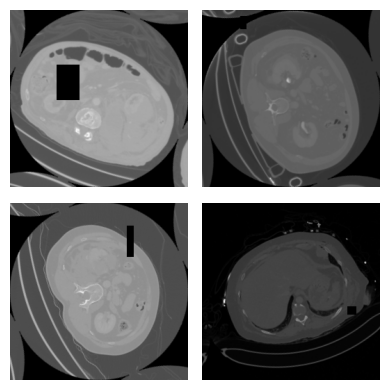

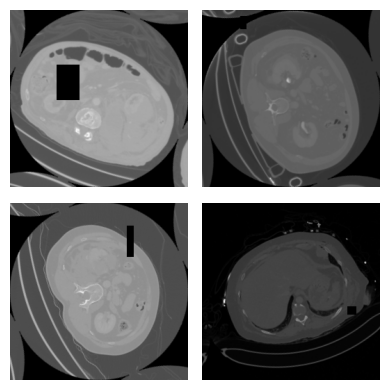

In [ ]:
keras_cv.visualization.plot_image_gallery(
    images=images,
    value_range=(0, 1),
    rows=2,
    cols=2,
)

Model

Resnet50

In [ ]:
def build_model(warmup_steps, decay_steps):
    # Define Input
    inputs = keras.Input(shape=config.IMAGE_SIZE + [3,], batch_size=config.BATCH_SIZE)

    # Define Backbone
    backbone = keras_cv.models.ResNetBackbone.from_preset("resnet50_imagenet")
    backbone.include_rescaling = False
    x = backbone(inputs)

    # GAP to get the activation maps
    gap = keras.layers.GlobalAveragePooling2D()
    x = gap(x)

    # Define 'necks' for each head
    x_bowel = keras.layers.Dense(32, activation='silu')(x)
    x_extra = keras.layers.Dense(32, activation='silu')(x)
    x_liver = keras.layers.Dense(32, activation='silu')(x)
    x_kidney = keras.layers.Dense(32, activation='silu')(x)
    x_spleen = keras.layers.Dense(32, activation='silu')(x)

    # Define heads
    out_bowel = keras.layers.Dense(1, name='bowel', activation='sigmoid')(x_bowel) # use sigmoid to convert predictions to [0-1]
    out_extra = keras.layers.Dense(1, name='extra', activation='sigmoid')(x_extra) # use sigmoid to convert predictions to [0-1]
    out_liver = keras.layers.Dense(3, name='liver', activation='softmax')(x_liver) # use softmax for the liver head
    out_kidney = keras.layers.Dense(3, name='kidney', activation='softmax')(x_kidney) # use softmax for the kidney head
    out_spleen = keras.layers.Dense(3, name='spleen', activation='softmax')(x_spleen) # use softmax for the spleen head

    # Concatenate the outputs
    outputs = [out_bowel, out_extra, out_liver, out_kidney, out_spleen]

    # Create model
    print("[INFO] Building the model...")
    model = keras.Model(inputs=inputs, outputs=outputs)

    # Cosine Decay
    cosine_decay = keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=1e-4,
        decay_steps=decay_steps,
        alpha=0.0,
        warmup_target=1e-3,
        warmup_steps=warmup_steps,
    )

    # Compile the model
    optimizer = keras.optimizers.Adam(learning_rate=cosine_decay)
    loss = {
        "bowel":keras.losses.BinaryCrossentropy(),
        "extra":keras.losses.BinaryCrossentropy(),
        "liver":keras.losses.CategoricalCrossentropy(),
        "kidney":keras.losses.CategoricalCrossentropy(),
        "spleen":keras.losses.CategoricalCrossentropy(),
    }
    metrics = {
        "bowel":["accuracy"],
        "extra":["accuracy"],
        "liver":["accuracy"],
        "kidney":["accuracy"],
        "spleen":["accuracy"],
    }
    print("[INFO] Compiling the model...")
    model.compile(
        optimizer=optimizer,
      loss=loss,
      metrics=metrics
    )

    return model

Train

In [ ]:
# get image_paths and labels
print("[INFO] Building the dataset...")
train_paths = train_data.image_path.values; train_labels = train_data[config.TARGET_COLS].values.astype(np.float32)
valid_paths = val_data.image_path.values; valid_labels = val_data[config.TARGET_COLS].values.astype(np.float32)

# train and valid dataset
train_ds = build_dataset(image_paths=train_paths, labels=train_labels)
val_ds = build_dataset(image_paths=valid_paths, labels=valid_labels)

total_train_steps = train_ds.cardinality().numpy() * config.BATCH_SIZE * config.EPOCHS
warmup_steps = int(total_train_steps * 0.10)
decay_steps = total_train_steps - warmup_steps

print(f"{total_train_steps=}")
print(f"{warmup_steps=}")
print(f"{decay_steps=}")

[INFO] Building the dataset...
total_train_steps=96640
warmup_steps=9664
decay_steps=86976


In [ ]:
# build the model
print("[INFO] Building the model...")
model = build_model(warmup_steps, decay_steps)

# train
print("[INFO] Training...")
history = model.fit(
    train_ds,
    epochs=config.EPOCHS,
    validation_data=val_ds,
)

[INFO] Building the model...
94657128/94657128 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
[INFO] Building the model...
[INFO] Compiling the model...
[INFO] Training...
Epoch 1/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 790s 5s/step - bowel_accuracy: 0.9166 - extra_accuracy: 0.8669 - kidney_accuracy: 0.7653 - liver_accuracy: 0.6747 - loss: 2.8136 - spleen_accuracy: 0.6196 - val_bowel_accuracy: 0.5205 - val_extra_accuracy: 0.6967 - val_kidney_accuracy: 0.8113 - val_liver_accuracy: 0.8697 - val_loss: 8.2868 - val_spleen_accuracy: 0.6773
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 25s 155ms/step - bowel_accuracy: 0.5112 - extra_accuracy: 0.8627 - kidney_accuracy: 0.7906 - liver_accuracy: 0.7071 - loss: 4.8370 - spleen_accuracy: 0.5589 - val_bowel_accuracy: 0.5205 - val_extra_accuracy: 0.6967 - val_kidney_accuracy: 0.8113 - val_liver_accuracy: 0.8697 - val_loss: 3.9344 - val_spleen_accuracy: 0.6773
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 26s 161ms/step - bowel_accuracy: 0.4211 - extra_accuracy: 0.8527 - kidney_accu

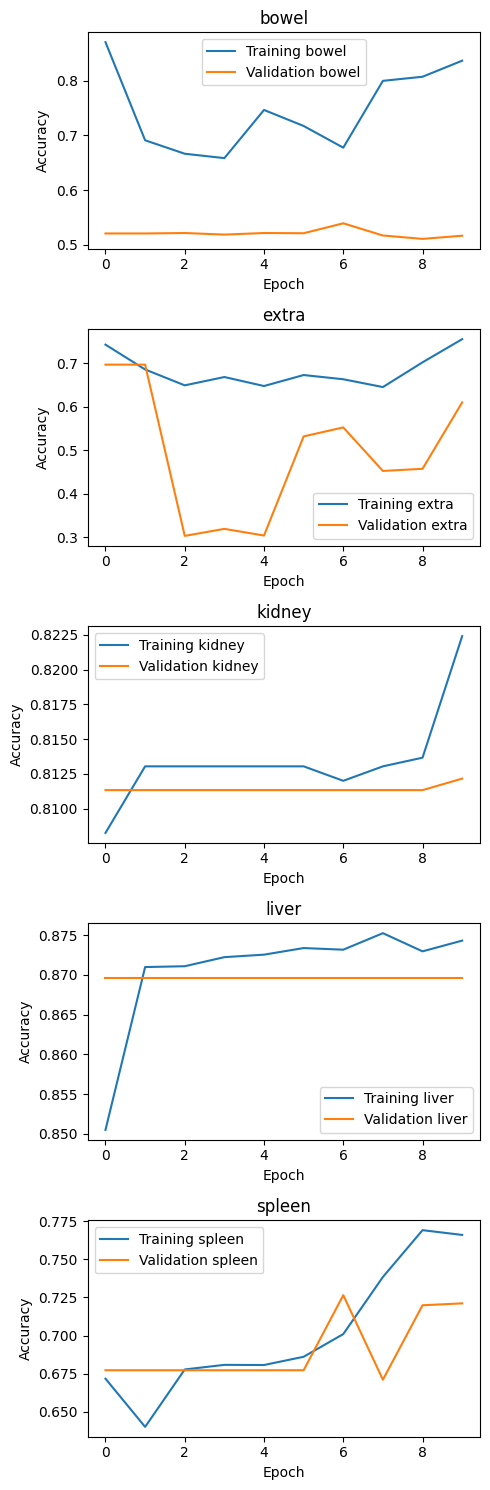

In [ ]:
# Create a 3x2 grid for the subplots
fig, axes = plt.subplots(5, 1, figsize=(5, 15))

# Flatten axes to iterate through them
axes = axes.flatten()

# Iterate through the metrics and plot them
for i, name in enumerate(["bowel", "extra", "kidney", "liver", "spleen"]):
    # Plot training accuracy
    axes[i].plot(history.history[name + '_accuracy'], label='Training ' + name)
    # Plot validation accuracy
    axes[i].plot(history.history['val_' + name + '_accuracy'], label='Validation ' + name)
    axes[i].set_title(name)
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Accuracy')
    axes[i].legend()

plt.tight_layout()
plt.show()

In [ ]:
# store best results
best_epoch = np.argmin(history.history['val_loss'])
best_loss = history.history['val_loss'][best_epoch]
best_acc_bowel = history.history['val_bowel_accuracy'][best_epoch]
best_acc_extra = history.history['val_extra_accuracy'][best_epoch]
best_acc_liver = history.history['val_liver_accuracy'][best_epoch]
best_acc_kidney = history.history['val_kidney_accuracy'][best_epoch]
best_acc_spleen = history.history['val_spleen_accuracy'][best_epoch]

# Find mean accuracy
best_acc = np.mean(
    [best_acc_bowel,
     best_acc_extra,
     best_acc_liver,
     best_acc_kidney,
     best_acc_spleen
])


print(f'>>>> BEST Loss  : {best_loss:.3f}\n>>>> BEST Acc   : {best_acc:.3f}\n>>>> BEST Epoch : {best_epoch}\n')
print('ORGAN Acc:')
print(f'  >>>> {"Bowel".ljust(15)} : {best_acc_bowel:.3f}')
print(f'  >>>> {"Extravasation".ljust(15)} : {best_acc_extra:.3f}')
print(f'  >>>> {"Liver".ljust(15)} : {best_acc_liver:.3f}')
print(f'  >>>> {"Kidney".ljust(15)} : {best_acc_kidney:.3f}')
print(f'  >>>> {"Spleen".ljust(15)} : {best_acc_spleen:.3f}')

>>>> BEST Loss  : 3.561
>>>> BEST Acc   : 0.700
>>>> BEST Epoch : 6

ORGAN Acc:
  >>>> Bowel           : 0.539
  >>>> Extravasation   : 0.552
  >>>> Liver           : 0.870
  >>>> Kidney          : 0.811
  >>>> Spleen          : 0.727


## Model Save

In [ ]:
#model.save(BASE_PATH + "/rsna_resnet.h5")